In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cY7D-V6iEy45sJ84zbh7LKNFA7vKkn_A' -O news.csv
!pip install transformers

--2022-11-03 20:15:03--  https://docs.google.com/uc?export=download&id=1cY7D-V6iEy45sJ84zbh7LKNFA7vKkn_A
Resolving docs.google.com (docs.google.com)... 209.85.200.139, 209.85.200.113, 209.85.200.102, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8fo61ccldhbcukv0om532gq8f44s3fmt/1667506500000/12963386087711609264/*/1cY7D-V6iEy45sJ84zbh7LKNFA7vKkn_A?e=download&uuid=826b0de2-978f-4337-a5bc-d9e1ac635e16 [following]
--2022-11-03 20:15:07--  https://doc-0g-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8fo61ccldhbcukv0om532gq8f44s3fmt/1667506500000/12963386087711609264/*/1cY7D-V6iEy45sJ84zbh7LKNFA7vKkn_A?e=download&uuid=826b0de2-978f-4337-a5bc-d9e1ac635e16
Resolving doc-0g-6o-docs.googleusercontent.com (doc-0g-6o-docs.googleusercontent.com)... 209.85.146.132, 2607:f8b0:

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import time
import numpy as np

# Preliminaries

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from transformers import DistilBertTokenizerFast, DistilBertModel
import torch
from tqdm import tqdm

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from numpy.random import RandomState
import gc

#pruning
import torch.nn.utils.prune as prune
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = pd.read_csv('news.csv')

encoder = LabelEncoder()
df.label = encoder.fit_transform(df.label)
df['titletext'] = df['title'] + ' ' + df['text']


train_texts, test_texts, train_labels, test_labels = train_test_split(df['titletext'].values.tolist(), df['label'].values.tolist(), test_size=.2)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.25)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'tiny-imagenet-2022.zip' is.

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Transformer_compression")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%%time

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

CPU times: user 2min 18s, sys: 401 ms, total: 2min 18s
Wall time: 2min 29s


In [6]:
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)
test_dataset = FakeNewsDataset(test_encodings, test_labels)

batch_size = 8
train_iter = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
valid_iter = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
test_iter = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

In [36]:


class Bert_Model(nn.Module):
    def __init__(self, classes):
        super(Bert_Model, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.out = nn.Linear(self.bert.config.hidden_size, classes)

    def forward(self, input, attention_mask):
        bert_output = self.bert(input, attention_mask = attention_mask)
        output = self.out(bert_output[1])
        return output

# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = './',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for model_inputs in train_loader:
            output = model(model_inputs['input_ids'].to(device), model_inputs['attention_mask'].to(device))
            loss = criterion(output, model_inputs['labels'].to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for model_inputs in valid_loader:
                        output = model(model_inputs['input_ids'].to(device), model_inputs['attention_mask'].to(device))
                        loss = criterion(output, model_inputs['labels'].to(device))
                        
                        valid_running_loss += loss.item()
                        
                        cleanup()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                    
            cleanup()
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

# Validation Function

def validate(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 1,
          eval_every = len(valid_iter) // 2,
          file_path = './',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for model_inputs in valid_loader:
            # output = model(model_inputs['input_ids'].to(device), model_inputs['attention_mask'].to(device))
            # loss = criterion(output, model_inputs['labels'].to(device))

            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()

            # # update running values
            # running_loss += loss.item()
            global_step += 1

            # evaluation step
            
            model.eval()
            with torch.no_grad():                    

                # validation loop
                # for model_inputs in valid_loader:
                output = model(model_inputs['input_ids'].to(device), model_inputs['attention_mask'].to(device))
                loss = criterion(output, model_inputs['labels'].to(device))
                
                valid_running_loss += loss.item()
                
                cleanup()

                # evaluation
                # average_train_loss = running_loss / eval_every
    average_valid_loss = valid_running_loss / len(valid_loader)
    # train_loss_list.append(average_train_loss)
    valid_loss_list.append(average_valid_loss)
    global_steps_list.append(global_step)

    # resetting running values
    # running_loss = 0.0                
    valid_running_loss = 0.0
    # model.train()

    # print progress
    print('Epoch [{}/{}], Step [{}/{}], Valid Loss: {:.4f}'
          .format(epoch+1, num_epochs, global_step, num_epochs*len(valid_loader),
                    average_valid_loss))
                
                # checkpoint
                # if best_valid_loss > average_valid_loss:
                #     best_valid_loss = average_valid_loss
                #     save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                #     save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                    
    cleanup()
    
    # save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Validation!')

# Evaluation Function
from sklearn.metrics import f1_score
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    eval_times = []
    
    with torch.no_grad():
        for model_inputs in test_loader:
                start = time.time()
                output = model(model_inputs['input_ids'].to(device), model_inputs['attention_mask'].to(device))
                eval_times.append(time.time() - start)
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(model_inputs['labels'].tolist())
    # print(f'Average inference time = {np.array(eval_times[:-2]).mean()}')
    # print('Classification Report:')
    # print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    # cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    # ax= plt.subplot()
    # sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    # ax.set_title('Confusion Matrix')

    # ax.set_xlabel('Predicted Labels')
    # ax.set_ylabel('True Labels')

    # ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    # ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred)

In [9]:
train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)
test_dataset = FakeNewsDataset(test_encodings, test_labels)

batch_size = 8
train_iter = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
valid_iter = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
test_iter = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)



In [9]:
model = Bert_Model(2).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer, num_epochs=5)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch [1/5], Step [238/2380], Train Loss: 0.2773, Valid Loss: 0.2598
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [1/5], Step [476/2380], Train Loss: 0.1256, Valid Loss: 0.1018
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/5], Step [714/2380], Train Loss: 0.0705, Valid Loss: 0.1419


KeyboardInterrupt: ignored

In [12]:
!ls drive/MyDrive/Transformer_compression/

compression	       Generate_approptiate_model.ipynb     pruning_bert.ipynb
compression_final.zip  Getting_familiar_with_MOROCCO.ipynb  Untitled0.ipynb
docker_fake.ipynb      measure_perfomance.ipynb


In [10]:
!cp drive/MyDrive/Transformer_compression/model_toy_bert.pt model.pt

In [11]:
best_model_clear = Bert_Model(2).to(device)

load_checkpoint('./model.pt', best_model_clear)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./model.pt


0.10179417499827233

Average inference time = 0.022032749880651
Classification Report:
              precision    recall  f1-score   support

           1     0.9785    0.9770    0.9777       651
           0     0.9757    0.9773    0.9765       616

    accuracy                         0.9771      1267
   macro avg     0.9771    0.9771    0.9771      1267
weighted avg     0.9771    0.9771    0.9771      1267

total time: 38.790677547454834


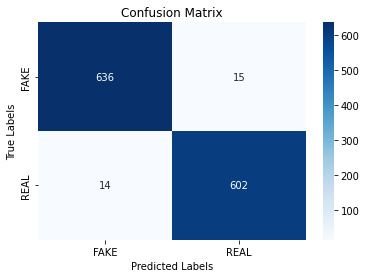

In [13]:
start = time.time()
acc, f1 = evaluate(best_model_clear, test_iter)
print(f'total time: {time.time() - start}')

In [27]:
f1

0.9637972646822205

In [32]:
best_model_pruning = Bert_Model(2).to(device)

load_checkpoint('./model.pt', best_model_pruning)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./model.pt


0.10179417499827233

In [33]:
import torch.nn.utils.prune as prune
import torch.nn.functional as F


for name, module in best_model_pruning.named_modules() :
    condition = isinstance(module, torch.nn.Linear) and (name.endswith('intermediate.dense') or name.endswith('output.dense') or name.startswith('bert.pooler.'))
    condition = condition and (not name.endswith('attention.output.dense')) and (not name.endswith('pooler.dense'))
    if condition:
        # print(name, module)
        prune.l1_unstructured(module, name='weight', amount=0.5)#0.3 nice
        prune.remove(module, 'weight')

  0%|          | 0/7 [00:00<?, ?it/s]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./model.pt


 14%|█▍        | 1/7 [00:46<04:37, 46.28s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./model.pt


 29%|██▊       | 2/7 [01:29<03:42, 44.44s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./model.pt


 43%|████▎     | 3/7 [02:11<02:54, 43.58s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./model.pt


 57%|█████▋    | 4/7 [02:54<02:09, 43.29s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./model.pt


 71%|███████▏  | 5/7 [03:37<01:26, 43.04s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./model.pt


 86%|████████▌ | 6/7 [04:20<00:42, 42.98s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./model.pt


100%|██████████| 7/7 [05:04<00:00, 43.43s/it]


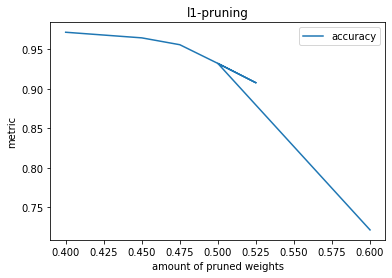

In [38]:
from tqdm import tqdm
amounts = np.array([0.4, 0.45, 0.475, 0.5, 0.525, 0.5, 0.6])
accs = []
f1s = []
for amount in tqdm(amounts):
    best_model_pruning = Bert_Model(2).to(device)
    load_checkpoint('./model.pt', best_model_pruning)
    for name, module in best_model_pruning.named_modules() :
        condition = isinstance(module, torch.nn.Linear) and (name.endswith('intermediate.dense') or name.endswith('output.dense') or name.startswith('bert.pooler.'))
        condition = condition and (not name.endswith('attention.output.dense')) and (not name.endswith('pooler.dense'))
        if condition:
            # print(name, module)
            prune.l1_unstructured(module, name='weight', amount=amount)#0.3 nice
            prune.remove(module, 'weight')
    acc, f1 = evaluate(best_model_pruning, test_iter)
    accs.append(acc)
    f1s.append(f1s)
accs = np.array(accs)
# f1s = np.array(f1s)
plt.plot(amounts, accs,label='accuracy')
# plt.plot(f1s, accs,label='f1-score')
# plt.axhline(count_parameters(best_model_clear),color='r', label='Original model')
plt.xlabel('amount of pruned weights')
plt.ylabel('metric')
plt.title('l1-pruning')
plt.legend()
plt.show()

In [21]:
best_model_SVD = Bert_Model(2).to(device)

load_checkpoint('./model.pt', best_model_SVD)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./model.pt


0.10179417499827233

In [22]:
from tqdm import tqdm
class SVD_dec(nn.Module):
    def __init__(self,input_size, output_size, r):
        super(SVD_dec, self).__init__()
        self.lin0 = nn.Linear(in_features=input_size, out_features=r, bias=False)
        self.lin1 = nn.Linear(in_features=r, out_features=r, bias=False)
        self.lin2 = nn.Linear(in_features=r, out_features=output_size, bias=True)

    def forward(self, x):
        # print(f'x_shape{x.size()}, self.lin0:{self.lin0.weight}')
        output = self.lin0(x)
        # print(f'output_shape{output.size()}, self.lin0:{self.lin1}')
        output = self.lin1(output)
        output = self.lin2(output)
        return output
# for name, module in best_model_SVD.named_modules() :
#     r = 740
#     # prune 20% of connections in all 2D-conv layers
#     # if isinstance(module, torch.nn.Conv2d):
#     #     prune.l1_unstructured(module, name='weight', amount=0.2)
#     # prune 40% of connections in all linear layers
#     condition = isinstance(module, torch.nn.Linear) and (name.endswith('intermediate.dense') or name.endswith('output.dense') or name.startswith('bert.pooler.'))
#     condition = condition and (not name.endswith('attention.output.dense')) and (not name.endswith('pooler.dense'))
#     if condition:
#         # print(name, module)
#         # print(module.weight)
#         with torch.no_grad():
#             u, s, v = torch.linalg.svd(module.weight)
#             print(f'u:{u.size()}, s:{s.size()}, v:{v.size()}')
#             U = u[:,:r]
#             S = s[:r]
#             V = v[:r,:]
#             module.weight = torch.nn.Parameter(torch.Tensor(torch.matmul(torch.matmul(U, torch.diag_embed(S)), V)).to(device))
#         # print(module.weight)
#         # prune.l1_unstructured(module, name='weight', amount=0.4)#0.3 nice
#         # prune.remove(module, 'weight')
#         # prune.l1_unstructured(module, name='weight', amount=0.4)

r = 680
for i in tqdm(range(12)):
    best_model_SVD.bert.encoder.layer[i].intermediate.dense = SVD_dec(768,3072,r)#nn.ModuleList([nn.Linear(in_features=768, out_features=r, bias=False),
                                                          # nn.Linear(in_features=r, out_features=r, bias=False),
                                                          # nn.Linear(in_features=r, out_features=3072, bias=True)])
    u, s, v = torch.linalg.svd(best_model_clear.bert.encoder.layer[i].intermediate.dense.weight)
    bias = best_model_clear.bert.encoder.layer[i].intermediate.dense.bias
    U = u[:,:r]
    S = s[:r]
    V = v[:r,:]
    best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin0.weight = torch.nn.Parameter(torch.Tensor(V).to(device))
    best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin1.weight = torch.nn.Parameter(torch.Tensor(torch.diag(S)).to(device))
    best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin2.weight = torch.nn.Parameter(torch.Tensor(U).to(device))
    best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin2.bias = torch.nn.Parameter(bias.to(device))
    
    best_model_SVD.bert.encoder.layer[i].output.dense = SVD_dec(3072,768,r)#nn.ModuleList([nn.Linear(in_features=3072, out_features=r, bias=False),
                                                          # nn.Linear(in_features=r, out_features=r, bias=False),
                                                          # nn.Linear(in_features=r, out_features=768, bias=True)])
    u, s, v = torch.linalg.svd(best_model_clear.bert.encoder.layer[i].output.dense.weight)
    bias = best_model_clear.bert.encoder.layer[i].output.dense.bias
    U = u[:,:r]
    S = s[:r]
    V = v[:r,:]
    best_model_SVD.bert.encoder.layer[i].output.dense.lin0.weight = torch.nn.Parameter(torch.Tensor(V).to(device))
    best_model_SVD.bert.encoder.layer[i].output.dense.lin1.weight = torch.nn.Parameter(torch.Tensor(torch.diag(S)).to(device))
    best_model_SVD.bert.encoder.layer[i].output.dense.lin2.weight = torch.nn.Parameter(torch.Tensor(U).to(device))
    best_model_SVD.bert.encoder.layer[i].output.dense.lin2.bias = torch.nn.Parameter(bias.to(device))

100%|██████████| 12/12 [00:04<00:00,  2.99it/s]


Average inference time = 0.015720895900847805
Classification Report:
              precision    recall  f1-score   support

           1     0.9901    0.8029    0.8867       624
           0     0.8384    0.9922    0.9088       643

    accuracy                         0.8990      1267
   macro avg     0.9142    0.8976    0.8978      1267
weighted avg     0.9131    0.8990    0.8979      1267

total time: 48.981574058532715


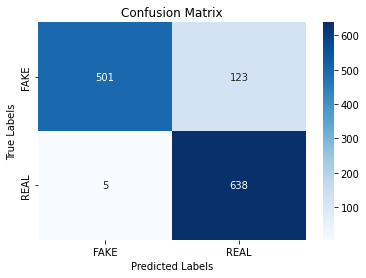

In [23]:
start = time.time()
evaluate(best_model_SVD, test_iter)
print(f'total time: {time.time() - start}')

In [ ]:
# rs = []
# for r in range(670, 760, step=10):
#     rs.append(r)
#     best_model = Bert_Model(2).to(device)
#     load_checkpoint('./model.pt', best_model)
#     for name, module in best_model.named_modules() :
#         r = 740
#         # prune 20% of connections in all 2D-conv layers
#         # if isinstance(module, torch.nn.Conv2d):
#         #     prune.l1_unstructured(module, name='weight', amount=0.2)
#         # prune 40% of connections in all linear layers
#         condition = isinstance(module, torch.nn.Linear) and (name.endswith('intermediate.dense') or name.endswith('output.dense') or name.startswith('bert.pooler.'))
#         condition = condition and (not name.endswith('attention.output.dense')) and (not name.endswith('pooler.dense'))
#         if condition:
#             # print(name, module)
#             # print(module.weight)
#             with torch.no_grad():
#                 u, s, v = torch.linalg.svd(module.weight)
#                 print(f'u:{u.size()}, s:{s.size()}, v:{v.size()}')
#                 U = u[:,:r]
#                 S = s[:r]
#                 V = v[:r,:]
#                 module.weight = torch.nn.Parameter(torch.Tensor(torch.matmul(torch.matmul(U, torch.diag_embed(S)), V)).to(device))
#             # print(module.weight)
#             # prune.l1_unstructured(module, name='weight', amount=0.4)#0.3 nice
#             # prune.remove(module, 'weight')
#             # prune.l1_unstructured(module, name='weight', amount=0.4)
#     evaluate(best_model, test_iter)
#     # optimizer = optim.Adam(model.parameters(), lr=2e-5)

#     # validate(model=best_model, optimizer=optimizer, num_epochs=5)
#     # evaluate(best_model, test_iter)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
normal_n_params = count_parameters(best_model_clear)
normal_n_params

109483778

In [ ]:
from tqdm import tqdm
num_params = []
# class SVD_dec(nn.Module):
#     def __init__(self,input_size, output_size, r):
#         super(SVD_dec, self).__init__()
#         self.lin0 = nn.Linear(in_features=input_size, out_features=r, bias=False)
#         self.lin1 = nn.Linear(in_features=r, out_features=r, bias=False)
#         self.lin2 = nn.Linear(in_features=r, out_features=output_size, bias=True)

#     def forward(self, x):
#         # print(f'x_shape{x.size()}, self.lin0:{self.lin0.weight}')
#         output = self.lin0(x)
#         # print(f'output_shape{output.size()}, self.lin0:{self.lin1}')
#         output = self.lin1(output)
#         output = self.lin2(output)
#         return output

class SVD_dec(nn.Module):
    def __init__(self,input_size, output_size, r):
        super(SVD_dec, self).__init__()
        self.lin0 = nn.Linear(in_features=input_size, out_features=r, bias=False)
        # self.lin1 = nn.Linear(in_features=r, out_features=r, bias=False)
        self.lin2 = nn.Linear(in_features=r, out_features=output_size, bias=True)

    def forward(self, x):
        # print(f'x_shape{x.size()}, self.lin0:{self.lin0.weight}')
        output = self.lin0(x)
        # print(f'output_shape{output.size()}, self.lin0:{self.lin1}')
        # output = self.lin1(output)
        output = self.lin2(output)
        return output
# for r in range(300,768, 50):
#     best_model_SVD = Bert_Model(2).to(device)
#     for i in tqdm(range(12)):
#         best_model_SVD.bert.encoder.layer[i].intermediate.dense = SVD_dec(768,3072,r)#nn.ModuleList([nn.Linear(in_features=768, out_features=r, bias=False),
#                                                               # nn.Linear(in_features=r, out_features=r, bias=False),
#                                                               # nn.Linear(in_features=r, out_features=3072, bias=True)])
#         u, s, v = torch.linalg.svd(best_model_clear.bert.encoder.layer[i].intermediate.dense.weight)
#         bias = best_model_clear.bert.encoder.layer[i].intermediate.dense.bias
#         U = u[:,:r]
#         S = s[:r]
#         V = v[:r,:]
#         best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin0.weight = torch.nn.Parameter(torch.Tensor(V).to(device))
#         best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin1.weight = torch.nn.Parameter(torch.Tensor(torch.diag(S)).to(device))
#         best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin2.weight = torch.nn.Parameter(torch.Tensor(U).to(device))
#         best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin2.bias = torch.nn.Parameter(bias.to(device))
        
#         best_model_SVD.bert.encoder.layer[i].output.dense = SVD_dec(3072,768,r)#nn.ModuleList([nn.Linear(in_features=3072, out_features=r, bias=False),
#                                                               # nn.Linear(in_features=r, out_features=r, bias=False),
#                                                               # nn.Linear(in_features=r, out_features=768, bias=True)])
#         u, s, v = torch.linalg.svd(best_model_clear.bert.encoder.layer[i].output.dense.weight)
#         bias = best_model_clear.bert.encoder.layer[i].output.dense.bias
#         U = u[:,:r]
#         S = s[:r]
#         V = v[:r,:]
#         best_model_SVD.bert.encoder.layer[i].output.dense.lin0.weight = torch.nn.Parameter(torch.Tensor(V).to(device))
#         best_model_SVD.bert.encoder.layer[i].output.dense.lin1.weight = torch.nn.Parameter(torch.Tensor(torch.diag(S)).to(device))
#         best_model_SVD.bert.encoder.layer[i].output.dense.lin2.weight = torch.nn.Parameter(torch.Tensor(U).to(device))
#         best_model_SVD.bert.encoder.layer[i].output.dense.lin2.bias = torch.nn.Parameter(bias.to(device))
#     num_params.append(count_parameters(best_model_SVD))

for r in range(318,769, 50):
    best_model_SVD = Bert_Model(2).to(device)
    for i in tqdm(range(12)):
        best_model_SVD.bert.encoder.layer[i].intermediate.dense = SVD_dec(768,3072,r)#nn.ModuleList([nn.Linear(in_features=768, out_features=r, bias=False),
                                                              # nn.Linear(in_features=r, out_features=r, bias=False),
                                                              # nn.Linear(in_features=r, out_features=3072, bias=True)])
        u, s, v = torch.linalg.svd(best_model_clear.bert.encoder.layer[i].intermediate.dense.weight)
        bias = best_model_clear.bert.encoder.layer[i].intermediate.dense.bias
        U = u[:,:r]
        S = s[:r]
        V = v[:r,:]
        best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin0.weight = torch.nn.Parameter(torch.Tensor(V).to(device))
        # best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin1.weight = torch.nn.Parameter(torch.Tensor(torch.diag(S)).to(device))
        best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin2.weight = torch.nn.Parameter(torch.Tensor(torch.diag(U).matmul(S)).to(device))
        best_model_SVD.bert.encoder.layer[i].intermediate.dense.lin2.bias = torch.nn.Parameter(bias.to(device))
        
        best_model_SVD.bert.encoder.layer[i].output.dense = SVD_dec(3072,768,r)#nn.ModuleList([nn.Linear(in_features=3072, out_features=r, bias=False),
                                                              # nn.Linear(in_features=r, out_features=r, bias=False),
                                                              # nn.Linear(in_features=r, out_features=768, bias=True)])
        u, s, v = torch.linalg.svd(best_model_clear.bert.encoder.layer[i].output.dense.weight)
        bias = best_model_clear.bert.encoder.layer[i].output.dense.bias
        U = u[:,:r]
        S = s[:r]
        V = v[:r,:]
        best_model_SVD.bert.encoder.layer[i].output.dense.lin0.weight = torch.nn.Parameter(torch.Tensor(V).to(device))
        # best_model_SVD.bert.encoder.layer[i].output.dense.lin1.weight = torch.nn.Parameter(torch.Tensor(torch.diag(S)).to(device))
        best_model_SVD.bert.encoder.layer[i].output.dense.lin2.weight = torch.nn.Parameter(torch.Tensor(torch.diag(U).matmul(S)).to(device))
        best_model_SVD.bert.encoder.layer[i].output.dense.lin2.bias = torch.nn.Parameter(bias.to(device))
    num_params.append(count_parameters(best_model_SVD))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 12/12 [00:19<00:00,  1.63s/it]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.

In [ ]:
number_of_parameters = np.array(num_params)


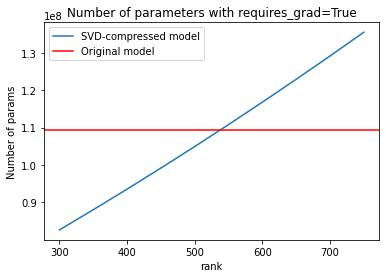

In [ ]:
plt.plot(np.arange(300,768, 50), number_of_parameters,label='SVD-compressed model')
plt.axhline(normal_n_params,color='r', label='Original model')
plt.xlabel('rank')
plt.ylabel('Number of params')
plt.title('Number of parameters with requires_grad=True')
plt.legend()
plt.show()

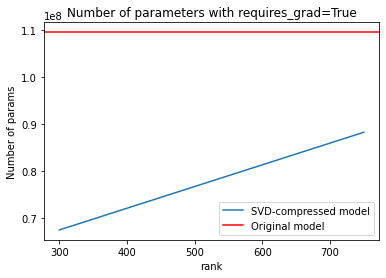

In [ ]:
number_of_parameters = np.array(num_params)

plt.plot(np.arange(300,768, 50), number_of_parameters,label='SVD-compressed model')
plt.axhline(count_parameters(best_model_clear),color='r', label='Original model')
plt.xlabel('rank')
plt.ylabel('Number of params')
plt.title('Number of parameters with requires_grad=True')
plt.legend()
plt.show()

In [ ]:
np.arange(300,768, 50)
number_of_parameters

array([67514138, 69818138, 72122138, 74426138, 76730138, 79034138,
       81338138, 83642138, 85946138, 88250138])